In [1]:
#todo 导入库
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [8]:
trans = [ 1/9, 5/9,  3/9,]
for i in range(1, len(trans)):
	trans[i] = trans[i -1 ] + trans[i]
	print('{}= {} + {}'.format(trans[i] , trans[i -1 ] , trans[i]))

0.6666666666666667= 0.1111111111111111 + 0.6666666666666667
1.0= 0.6666666666666667 + 1.0


In [2]:
#todo 配置训练环境和超参数
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
'''配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs'''
batch_size = 256
num_workers = 4  # 对于Windows用户，这里应设置为0，否则会出现多线程错误
lr = 1e-4
epochs = 20
print(device)
torch.cuda.is_available()
from torchvision.datasets import CIFAR10

cuda:0


In [10]:
#todo 读取数据【以fashMnist为例】
from torchvision import transforms

image_size = 28
data_transform = transforms.Compose(
    [
        transforms.ToPILImage(),  #mark这一步取决于后续的数据读取方式，如果使用内置数据集则不需要
        transforms.Resize(image_size),
        transforms.ToTensor()
    ]
)

In [ ]:
'''
#读取方式一：使用torchvision自带数据集，下载可能需要一段时间
from torchvision import datasets
train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=data_transform)
test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=data_transform)
'''

In [11]:
'''#读取方式二：读入csv格式的数据，自行构建Dataset类 ,
dataset说明详见：https://datawhalechina.github.io/thorough-pytorch/%E7%AC%AC%E4%B8%89%E7%AB%A0/3.3%20%E6%95%B0%E6%8D%AE%E8%AF%BB%E5%85%A5.html
'''


## 自行构建Dataset类,读入csv格式的数据，
class FMDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df  #传入的dataframe
        self.transform = transform
        self.images = df.iloc[:, 1:].values.astype(np.uint8)
        self.labels = df.iloc[:, 0].values

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28, 1)  #输入是（1，764） 重新reshape
        label = int(self.labels[idx])
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = torch.tensor(image / 255., dtype=torch.float)  #读进来的数据转化成Tnesor
        label = torch.tensor(label, dtype=torch.long)
        return image, label


train_df = pd.read_csv(r"D:\D数据盘\PycharmProjects\pythonProject\dataSet\fashion-mnist\fashion-mnist_train.csv")
test_df = pd.read_csv(r"D:\D数据盘\PycharmProjects\pythonProject\dataSet\fashion-mnist\fashion-mnist_test.csv")
train_data = FMDataset(train_df, data_transform)
test_data = FMDataset(test_df, data_transform)

torch.Size([256, 1, 28, 28]) torch.Size([256])


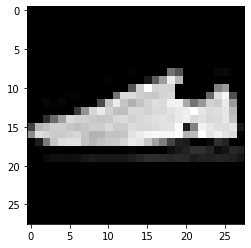

In [12]:
## Dataloader加载数据
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

## 查看载入数据是否正确
import matplotlib.pyplot as plt

image, label = next(iter(test_loader))
print(image.shape,  label.shape)#迭代器每次迭代256张图出来image来接收，对于image来说就是一个256张单通道28*28的list（即256，1，28，28）
plt.imshow(image[0][0], cmap="gray")

In [55]:
print(image)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

In [13]:
#todo 模型设计[CNN为例]
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)

        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)

        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64 * 4 * 4)
        x = self.fc(x)
        return x


model = Net()
model = model.cuda()
# model = nn.DataParallel(model).cuda()   # 多卡训练时的写法

In [14]:
#todo 设定损失函数,优化器
'''
使用torch.nn模块自带的CrossEntropy损失
PyTorch会自动把整数型的label转为one-hot型，用于计算CE loss
这里需要确保label是从0开始的，同时模型不加softmax层（使用logits计算）,这也说明了PyTorch训练中各个部分不是独立的，需要通盘考虑
'''
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [15]:
#todo 训练和测试（验证）
'''
各自封装成函数，方便后续调用
关注两者的主要区别：
    1：模型状态设置
    2:是否需要初始化优化器
    3:是否需要将loss传回到网络
    4:是否需要每步更新optimizer
'''
def train(epoch):
    model.train()#区别1
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cuda(), label.cuda()
        optimizer.zero_grad()  ##区别2 清零梯度，即优化器初始化
        #输入数据-》计算误差-》反向传播-》更新梯度
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()#区别4
        train_loss += loss.item() * data.size(0)
        '''
        # data.size(0)是当前批次的样本数，乘以样本数是因为求误差公式1/n (y-yhat)^2，误差loss是所有样本的和再取平均。
        所以在for单次是一个批次样本的loss总和，后面for外部就是总train_loss/len(train_loader.dataset)【总误差/除以整个数据集样本数量】
        这也是为什么打印出来loss越来越大，因为是样本的误差和
        '''
        # print('train ===now train_loss is {}'.format(train_loss))
    train_loss = train_loss / len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

def val(epoch):
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():  #区别3
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()
            output = model(data)
            preds = torch.argmax(output,1)  #返回指定维度最大值的序号,max是返回 value，idx【https://blog.csdn.net/qq_46092061/article/details/120612102】
            gt_labels.append(label.cpu().data.numpy()) #添加这个batch中真实值的label
            pred_labels.append(preds.cpu().data.numpy()) #添加这个batch中预测值的label
            loss = criterion(output, label)
            val_loss += loss.item() * data.size(0)
    val_loss = val_loss / len(test_loader.dataset)
    ''' debug
    print(len(gt_labels)) # 结果40,因为10000张图片10000/256=39.0625≈40
    print(gt_labels) # 结果为一个含有40个list,每个list有256个预测值的list
    '''
    '''计算acc'''
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels) #合并真实值、预测值的标签
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

Epoch: 1 	Training Loss: 0.686951
Epoch: 1 	Validation Loss: 0.471564, Accuracy: 0.830800
Epoch: 2 	Training Loss: 0.432371
Epoch: 2 	Validation Loss: 0.355756, Accuracy: 0.873900
Epoch: 3 	Training Loss: 0.367457
Epoch: 3 	Validation Loss: 0.315705, Accuracy: 0.882900
Epoch: 4 	Training Loss: 0.332193
Epoch: 4 	Validation Loss: 0.279223, Accuracy: 0.898700
Epoch: 5 	Training Loss: 0.308863
Epoch: 5 	Validation Loss: 0.285407, Accuracy: 0.896000
Epoch: 6 	Training Loss: 0.291494
Epoch: 6 	Validation Loss: 0.263041, Accuracy: 0.905400
Epoch: 7 	Training Loss: 0.278233
Epoch: 7 	Validation Loss: 0.251713, Accuracy: 0.907100
Epoch: 8 	Training Loss: 0.262124
Epoch: 8 	Validation Loss: 0.239732, Accuracy: 0.909100
Epoch: 9 	Training Loss: 0.252581
Epoch: 9 	Validation Loss: 0.232857, Accuracy: 0.911800
Epoch: 10 	Training Loss: 0.245607
Epoch: 10 	Validation Loss: 0.241957, Accuracy: 0.907500
Epoch: 11 	Training Loss: 0.235822
Epoch: 11 	Validation Loss: 0.225607, Accuracy: 0.916300
Epoch:

In [16]:
#todo 保存/调用模型
save_path = "./FahionModel.pkl"
## 模型与参数一起保存
torch.save(model, save_path)# model.state_dict()仅保存参数，重新使用时
seq_net1 = torch.load(save_path)
## 仅保存模型参数，需要重新建立模型才可使用
torch.save(model.state_dict(), save_path)
seq_net1 = Net()
seq_net1.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
if not None:
    print(1)